# 텍스트 순차열 데이터 예측 Template

# 데이터 준비

In [14]:
import numpy as np
import matplotlib.pyplot as plt


## 기반 문자열 생성

In [15]:
BASE_STRING = "abcde12345"
text_data = BASE_STRING*10
CATEGORY_NUM = len(BASE_STRING)

In [16]:
print(text_data)

abcde12345abcde12345abcde12345abcde12345abcde12345abcde12345abcde12345abcde12345abcde12345abcde12345


In [17]:
SEQUENCE_LENGTH = 5
OFFSET = 1

## 입출력 데이터 생성

'abcde12345abcde'의 문자열로 다음의 입출력 데이터를 생성한다.
```
'abcde' -> '1'
'bcde1' -> '2'
'cde12' -> '3'
'de123' -> '4'
...
'5abcd' -> 'e'
```

In [18]:
raw_x = []
raw_y = []

for i in range(len(text_data)):
  if i+SEQUENCE_LENGTH+OFFSET >= len(text_data): break
  raw_x.append(text_data[i:i+SEQUENCE_LENGTH])
  raw_y.append(text_data[i+SEQUENCE_LENGTH+OFFSET-1])
#            0         1         2      
#            012345678901234567890123456789
# textdata = abcde12345abcde12345abcde12345
#               i = 3
#               <-x->   = [3:8] = 'de123'
#                    y  = [8]   = '4'


In [19]:
print(len(raw_x))
# len(raw_x) = 94 = len(text_data) - SEQUENCE_LENGTH - OFFSET = 100 - 5 - 1

94


## 데이터를 2차원 벡터화 하기

RNN은 2차원 데이터를 입력으로 받는다. 1차원 문자열의 각 문자를 one-hot 인코딩하여 2차원 데이터로 만드렁 준다.<br>
입력 데이터와 출력 데이터를 다음의 형태로 준비한다.<br>
입력 데이터
```
문자열 'abc12'을 인코딩한
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
```

출력 데이터
```
문자열 '3'을 인코딩한
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
```



인코딩 디코딩을 위한 유틸 클래스 CharacterTable

In [20]:
class CharacterTable:
    """ 특정 문자열 집합을 가지고:
    + one-hot 인코딩
    + one-hot된 혹은 숫자로 인코딩된 값을 원 무자열로 디코딩
    + softmax 같은 확율 벡터를 원 문자열로 디코딩
    """

    def __init__(self, chars):
        """문자 테이블을 초기화
        # Arguments
            chars: 입력에 사용되는 문자들
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        # self.char_indices = { ' ': 0, 
        #                       '+': 1,
        #                       '0': 2, 
        #                       '1': 3, 
        #                       ...
        #                       '9': 11}
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        # self.indices_char = { 0: ' ', 
        #                       1: '+', 
        #                       2: '0', 
        #                       3: '1', 
        #                       ...
        #                       11: '9'}

    def encode(self, C):
        """전달된 문자열 C를 One-hot 인코딩 한다.
        # Arguments
            C: 인코딩할 문자열. 예 ' 123+45'
        """
        x = np.zeros((len(C), len(self.chars)))
        for i, c in enumerate(C): # 각 자리 문자마다
            x[i, self.char_indices[c]] = 1 # 각 줄의 index만 1로 만든다. one-hot encoding한다.

        # 반환되는 x는 num_rows의 행이고, 각 행은 각 문자에 대한 one-hot 인코딩된 값이다.
        return x

    def decode(self, x, calc_argmax=True):
        """전달된 벡터값 혹은 2D 배열을 해당 문자열로 디코딩한다.
        # Arguments
            x: 벡터 혹은 one-hot 인코딩된 2D 배열 혹은 softmax된 확률 2D 배열 
               혹은 calc_argmax=False일 때는 문자 인덱스 벡터
            calc_argmax: 최대 값의 index 값을 찾을 지 여부. default는 True
        """

        # one-hot 인코딩 혹은 softmax 값이면 최대 index를 구한다.
        if calc_argmax:
            # x = [ [0 0 0 0 1 0 0 0 0 0 0 0]
            #       [0 0 0 0 0 1 0 0 0 0 0 0]
            #       [0 0 0 0 0 0 1 0 0 0 0 0]]
            x = x.argmax(axis=-1)
            # x = [ 4 5 6 ]
        return "".join(self.indices_char[x] for x in x)


In [21]:
ctable = CharacterTable(BASE_STRING)

다음은 인코딩, 디코딩 예이다.

In [22]:
# 원 문자열
org_str = 'abc12'
print(f"org_str='{org_str}'")

# 인코딩된 값
encoded = ctable.encode(org_str)
# [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]    <==== 'a'
#  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]    <==== 'b'
#  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]    <==== 'c'
#  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]    <==== '1'
#  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]   <==== '2'
print(f"encoded=\n{encoded}")
print(f"encoded.shape={encoded.shape}")

# 다시 디코딩해서 원복한 값
decoded = ctable.decode(encoded)
print(f"decoded='{decoded}'")

org_str='abc12'
encoded=
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
encoded.shape=(5, 10)
decoded='abc12'


In [23]:
print(raw_x[0], raw_y[0])

abcde 1


In [24]:
print("Vectorization...")

x = np.zeros((len(raw_x), len(raw_x[0]), CATEGORY_NUM), dtype=np.bool)
y = np.zeros((len(raw_y), len(raw_y[0]), CATEGORY_NUM), dtype=np.bool)
for i, sentence in enumerate(raw_x):
    x[i] = ctable.encode(sentence)
for i, sentence in enumerate(raw_y):
    y[i] = ctable.encode(sentence)

print(x.shape)
print(y.shape)

shuffled_index = np.arange(len(x))
np.random.shuffle(shuffled_index)
x = x[shuffled_index]
y = y[shuffled_index]


split_at = int(len(x)*0.9)
(train_x, test_x) = x[:split_at], x[split_at:]
(train_y, test_y) = y[:split_at], y[split_at:]

print("Training Data:")
print(train_x.shape)
print(train_y.shape)

print("Test Data:")
print(test_x.shape)
print(test_y.shape)


Vectorization...
(94, 5, 10)
(94, 1, 10)
Training Data:
(84, 5, 10)
(84, 1, 10)
Test Data:
(10, 5, 10)
(10, 1, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


준비된 데이터는 다음과 같습니다.

In [25]:
print("train_x[0]\n", train_x[0].astype(np.int8))
print()
print("train_y[0]\n", train_y[0].astype(np.int8))

train_x[0]
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]

train_y[0]
 [[0 0 0 0 0 1 0 0 0 0]]


준비된 데이터는 인코딩된 값들입니다. 디코딩에서 본 원 문자열은 다음과 같습니다.

In [26]:
for i in range(10):
  print("'"+ctable.decode(train_x[i])+"' -> '"+ctable.decode(train_y[i])+"'")

'12345' -> 'a'
'cde12' -> '3'
'2345a' -> 'b'
'e1234' -> '5'
'cde12' -> '3'
'e1234' -> '5'
'12345' -> 'a'
'e1234' -> '5'
'abcde' -> '1'
'abcde' -> '1'


# Template

## LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 128)           0         
 )                                                               
                                                                 
 dense (Dense)               (None, 1, 10)             1290      
                                                                 
Total params: 72,458
Trainable params: 72,458
Non-trainable params: 0
_________________________________________________________________


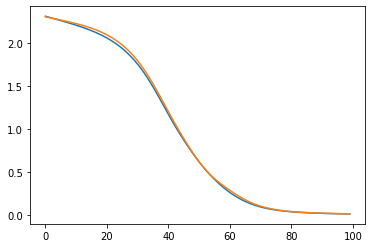

1/1 [==============================] - 0s 21ms/step - loss: 0.0172 - accuracy: 1.0000
loss= 0.017232609912753105
acc= 1.0


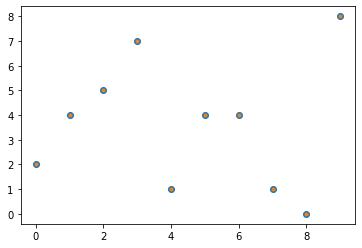

In [27]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)


model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## GRU

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               53760     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 128)           0         
 or)                                                             
                                                                 
 dense_1 (Dense)             (None, 1, 10)             1290      
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


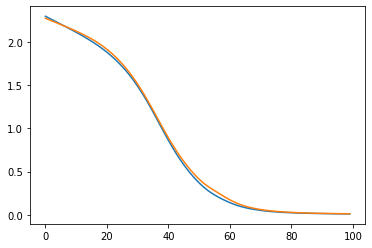

1/1 [==============================] - 0s 21ms/step - loss: 0.0119 - accuracy: 1.0000
loss= 0.011890897527337074
acc= 1.0


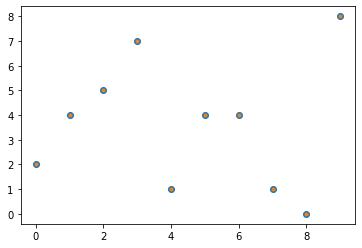

In [28]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(GRU(128, input_shape=input_shape))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## Bidirectional + LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              142336    
 l)                                                              
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 256)           0         
 or)                                                             
                                                                 
 dense_2 (Dense)             (None, 1, 10)             2570      
                                                                 
Total params: 144,906
Trainable params: 144,906
Non-trainable params: 0
_________________________________________________________________


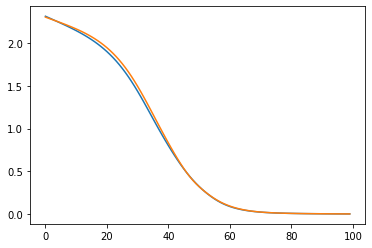

1/1 [==============================] - 0s 21ms/step - loss: 0.0056 - accuracy: 1.0000
loss= 0.005590328015387058
acc= 1.0


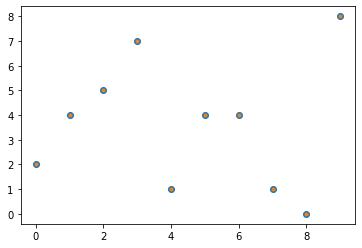

In [29]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Bidirectional(LSTM(128), input_shape=input_shape))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## Bidirectional + GRU

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 256)              107520    
 nal)                                                            
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 256)           0         
 or)                                                             
                                                                 
 dense_3 (Dense)             (None, 1, 10)             2570      
                                                                 
Total params: 110,090
Trainable params: 110,090
Non-trainable params: 0
_________________________________________________________________


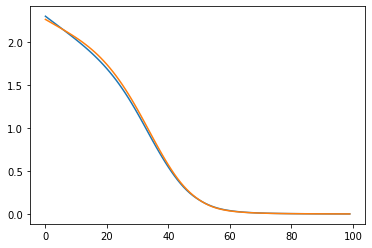

1/1 [==============================] - 0s 21ms/step - loss: 0.0038 - accuracy: 1.0000
loss= 0.003752372460439801
acc= 1.0


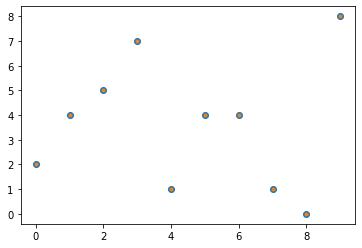

In [30]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Bidirectional(GRU(128), input_shape=input_shape))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## stacked

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            71168     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 128)           0         
 or)                                                             
                                                                 
 dense_4 (Dense)             (None, 1, 10)             1290      
                                                                 
Total params: 204,042
Trainable params: 204,042
Non-trainable params: 0
_________________________________________________________________


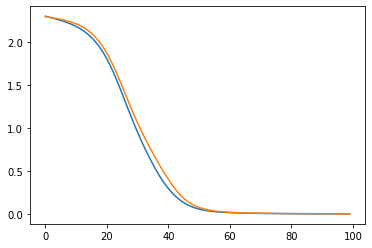

1/1 [==============================] - 0s 22ms/step - loss: 0.0055 - accuracy: 1.0000
loss= 0.005539268720895052
acc= 1.0


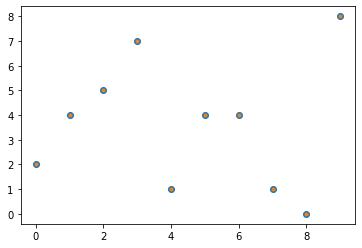

In [31]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(LSTM(128))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## CNN

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 32)             992       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 2, 32)             3104      
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                  

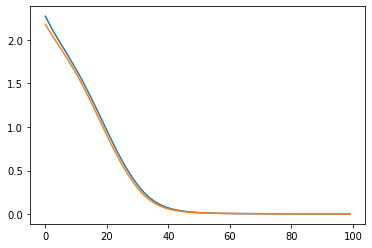

1/1 [==============================] - 0s 31ms/step - loss: 0.0028 - accuracy: 1.0000
loss= 0.0028419240843504667
acc= 1.0


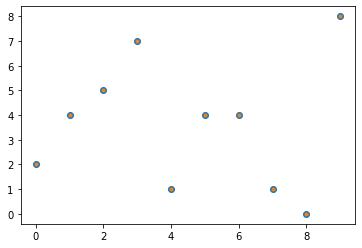

In [32]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Reshape

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Conv1D(32, 3, padding="same", input_shape=input_shape))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D())
model.add(Conv1D(32, 3, padding="same"))
model.add(Conv1D(32, 3, padding="same"))
model.add(MaxPooling1D())
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()

## CNN + LSTM

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 5, 32)             992       
                                                                 
 conv1d_5 (Conv1D)           (None, 5, 32)             3104      
                                                                 
 lstm_4 (LSTM)               (None, 128)               82432     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 1, 128)           0         
 or)                                                             
                                                                 
 dense_6 (Dense)             (None, 1, 10)             1290      
                                                                 
Total params: 87,818
Trainable params: 87,818
Non-trainable params: 0
__________________________________________________

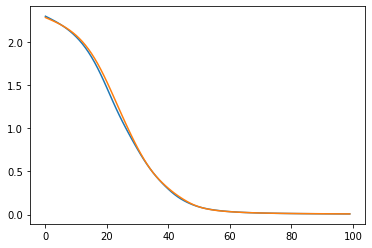

1/1 [==============================] - 0s 21ms/step - loss: 0.0077 - accuracy: 1.0000
loss= 0.007719897665083408
acc= 1.0


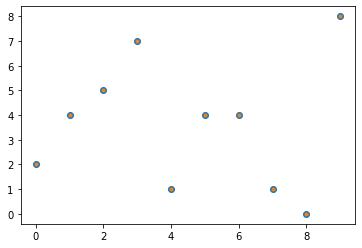

In [33]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Input, Reshape

input_shape = train_x.shape[1:]
# input_shape = (5,10)

model = keras.Sequential()
model.add(Conv1D(32, 3, padding="same", input_shape=input_shape))
model.add(Conv1D(32, 3, padding="same"))
model.add(LSTM(128))
model.add(RepeatVector(1))
model.add(Dense(CATEGORY_NUM, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs=100, verbose=0, validation_split=0.1, batch_size=128)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()



loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)



y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=-1)
test_y_index = np.argmax(test_y, axis=-1)

plt.plot(test_y_index, "o")
plt.plot(predicted, ".")
plt.show()